In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pydaptivefiltering as pdf

In [2]:
def generate_data(dim=500, Sx=1.0, Sn=1e-1, seed=0):
    rng = np.random.default_rng(seed)
    n = Sn * rng.standard_normal(dim)

    # x complexo ~ Sx*randn + i*Sx*randn (igual intenção do MATLAB)
    x = Sx * (rng.standard_normal(dim) + 1j * rng.standard_normal(dim))

    xl1 = np.zeros(dim, dtype=complex)
    xl2 = np.zeros(dim, dtype=complex)
    xl1[1:] = x[:-1]
    xl2[1:] = xl1[:-1]

    d = (-0.08*x - 0.15*xl1 + 0.14*xl2
         + 0.055*(x**2) + 0.3*x*xl2 - 0.16*(xl1**2) + 0.14*(xl2**2)
        ) + n  # n é real, soma ok

    return x, d

def run_crbf(dim=2000, Nneur=5, ur=3e-1, uw=3e-1, us=1e-1, seed=0):

    x, d = generate_data(dim=dim, Sx=1.0, Sn=1e-2, seed=seed)

    crbf = pdf.ComplexRBF(
        n_neurons=Nneur,
        input_dim=3,        
        ur=ur, uw=uw, us=us,
        sigma_init=2.0,
        rng=np.random.default_rng(seed),
    )

    res = crbf.optimize(x, d, return_internal_states=True)
    e = np.asarray(res.errors).ravel()
    mse = np.abs(e)**2

    return res, mse, d

res, mse, d = run_crbf(seed=0)

In [3]:
def plot_crbf(res, d, win=200):
    """
    Gráficos interpretáveis para CRBF:

    (1) MSE instantâneo + média móvel (dB)
    (2) |e[k]| (magnitude do erro)
    (3) d vs y (Re e Im) em um trecho final (zoom interpretável)
    (4) ||w[k]|| (norma dos pesos ao longo do tempo)
    (5) Pesos no plano complexo: início -> fim (setas por neurônio)
    """
    # -------- dados básicos --------
    y = np.asarray(res.outputs).ravel()
    e = np.asarray(res.errors).ravel()
    d = np.asarray(d).ravel()

    if y.shape != d.shape:
        raise ValueError(f"Shapes incompatíveis: y {y.shape} vs d {d.shape}")

    mse = np.abs(e)**2

    # -------- (1) MSE + média móvel --------
    w = int(win)
    if w <= 1:
        ma = mse
    else:
        kernel = np.ones(w) / w
        ma = np.convolve(mse, kernel, mode="same")

    plt.figure()
    plt.plot(10*np.log10(mse + 1e-12), label="inst |e|^2")
    plt.plot(10*np.log10(ma  + 1e-12), label=f"MA({w})")
    plt.title("Learning curve: |e[k]|^2 (dB) + média móvel")
    plt.xlabel("k")
    plt.ylabel("Potência do erro [dB]")
    plt.grid(True)
    plt.legend()
    plt.show()

    # -------- (2) Magnitude do erro --------
    plt.figure()
    plt.plot(np.abs(e))
    plt.title("Magnitude do erro: |e[k]|")
    plt.xlabel("k")
    plt.ylabel("|e[k]|")
    plt.grid(True)
    plt.show()

    # -------- (3) d vs y (Re/Im) com zoom no final --------
    N = len(d)
    tail = max(300, N // 10)  
    k0 = max(0, N - tail)
    kk = np.arange(k0, N)

    plt.figure()
    plt.plot(kk, d.real[k0:], label="Re{d}")
    plt.plot(kk, y.real[k0:], label="Re{y}")
    plt.title(f"Parte real (zoom final): k={k0}..{N-1}")
    plt.xlabel("k")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(kk, d.imag[k0:], label="Im{d}")
    plt.plot(kk, y.imag[k0:], label="Im{y}")
    plt.title(f"Parte imaginária (zoom final): k={k0}..{N-1}")
    plt.xlabel("k")
    plt.grid(True)
    plt.legend()
    plt.show()

    # -------- pesos --------
    W = np.asarray(res.coefficients)  

    if W.ndim != 2:
        raise ValueError(f"Esperava W 2D (T,Nneur). Veio {W.shape}")

    # -------- (4) ||w[k]|| --------
    wnorm = np.linalg.norm(W, axis=1)
    plt.figure()
    plt.plot(wnorm)
    plt.title("Estabilidade: norma dos pesos ||w[k]||")
    plt.xlabel("k")
    plt.ylabel("||w||")
    plt.grid(True)
    plt.show()


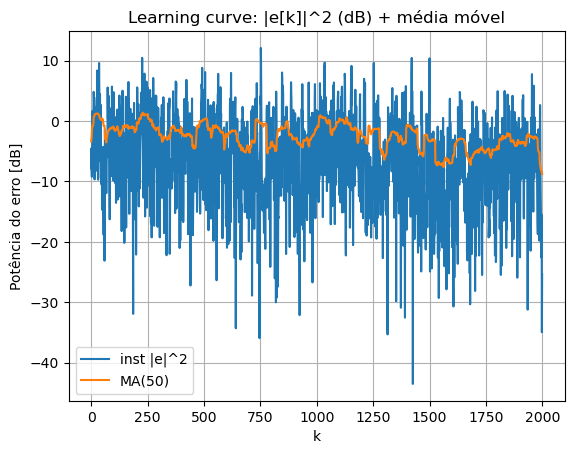

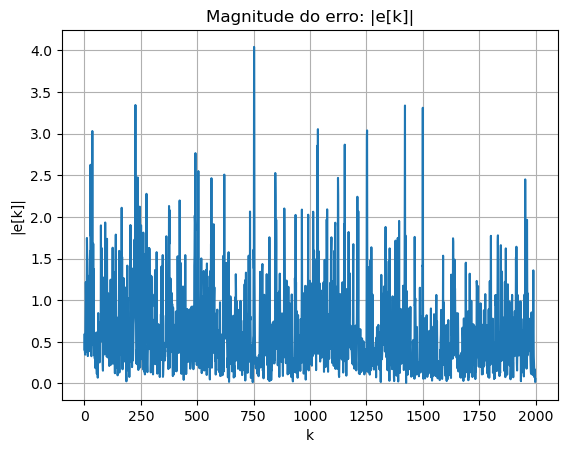

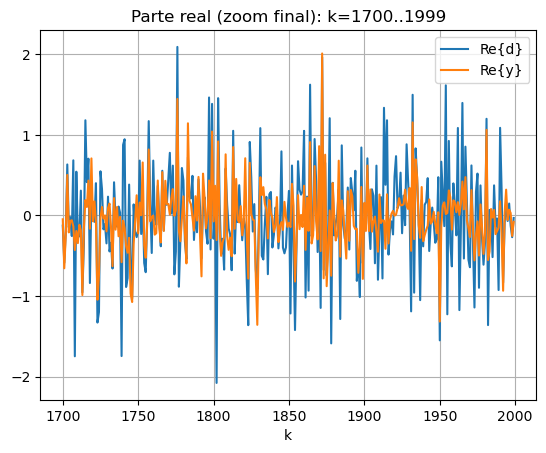

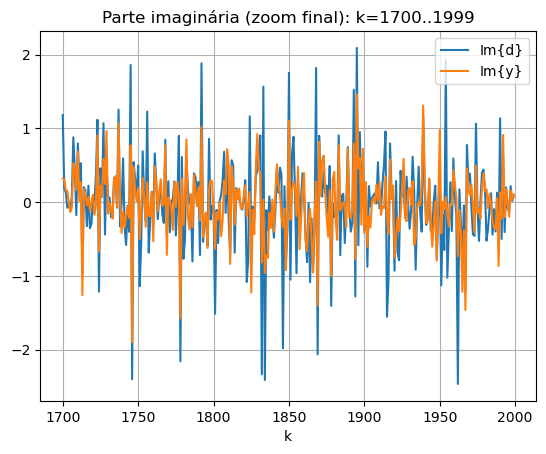

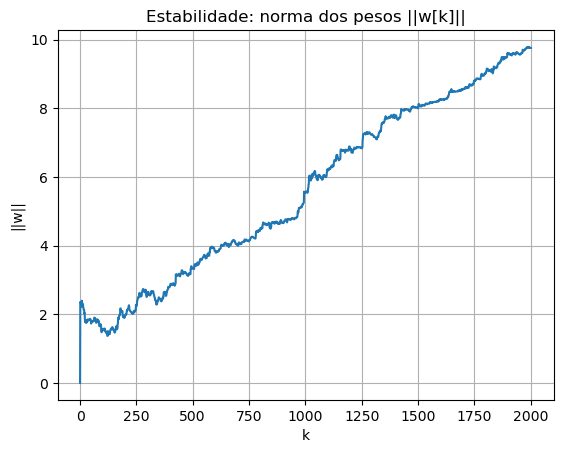

In [4]:
plot_crbf(res, d, win=50)